In [84]:
import numpy as np
import meshplot as mp
import results.runs as runs
import os
import matplotlib.pyplot as plt
import torch
import model.sdf_model as sdf_model
import trimesh

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Training curves

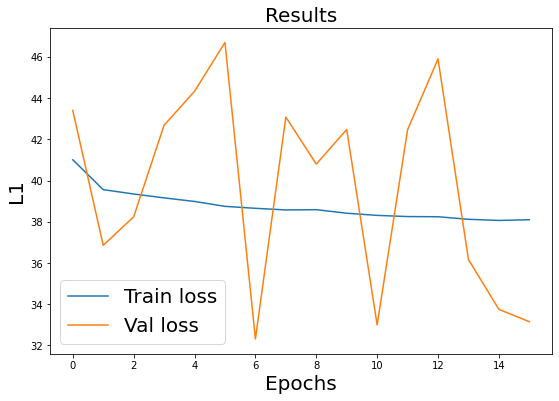

In [85]:
run_folder = '05_11_122748'
run_dir = os.path.join(os.path.dirname(runs.__file__), run_folder)
results_path = os.path.join(run_dir, 'results.npy')
results = np.load(results_path, allow_pickle=True).item()

train_loss = results['train']['loss']
val_loss = results['val']['loss']
plt.figure(figsize=(9, 6))
plt.title('Results', fontsize=20)
plt.plot(train_loss, label='Train loss')
plt.plot(val_loss, label='Val loss')
plt.xlabel('Epochs', fontsize=20)
plt.ylabel('L1', fontsize=20) 
plt.legend(fontsize=20)
plt.show()

Extract latent code:

In [89]:
latent_codes = torch.tensor(results['train']['latent_codes'][0])     # last one
latent_codes

tensor([[-5.7888e-07,  1.1278e-06,  1.2692e-07, -1.1041e-06,  1.1839e-06,
          8.9378e-07, -1.8229e-06,  1.6373e-06,  3.7894e-07, -1.3959e-06,
          4.5792e-07,  1.1884e-06, -1.2781e-06, -2.3453e-07, -6.1032e-07,
          5.1259e-07, -9.1369e-07,  2.3742e-07, -1.0815e-06,  5.6924e-07,
          1.4129e-06, -9.3270e-07,  4.4863e-07, -2.8099e-06, -1.0938e-06,
          8.3426e-07, -1.8274e-06,  1.2524e-06,  8.2380e-07,  2.1668e-06,
         -8.1916e-07, -5.2131e-08,  7.1477e-08,  1.5898e-06,  1.7292e-06,
         -1.7710e-06, -2.5931e-06,  6.5068e-08, -5.6625e-07, -8.3843e-07,
         -9.8932e-07,  2.1506e-06, -1.2074e-06, -4.5560e-07, -1.2671e-06,
         -2.1374e-06, -3.1930e-07, -7.7388e-07, -5.4114e-07,  1.1032e-06,
         -2.0141e-06,  1.0625e-06,  3.1222e-07, -1.0192e-06, -1.0298e-06,
         -2.4089e-07, -2.6672e-08, -6.6499e-07,  1.3510e-06,  3.1413e-07,
         -1.0432e-06,  1.3458e-06, -3.6676e-07, -3.2390e-07, -1.3544e-06,
         -1.1476e-06,  6.4287e-07,  1.

# Visualize mesh
First optimised latent code during training:

In [87]:
latent_code_idx = 2
run_folder = '04_11_161003'
run_dir = os.path.join(os.path.dirname(runs.__file__), run_folder)
weights_path = os.path.join(run_dir, 'weights.pt')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def extract_mesh(data, sdf):
    sdf_inside = data[(sdf.view(-1)>-0.01) & (sdf.view(-1)<0.01)]
    #sdf_inside = data[(sdf.view(-1)<0.01)]
    mesh = trimesh.voxel.ops.points_to_marching_cubes(sdf_inside.detach().cpu().numpy(), pitch=0.015)
    return mesh

model = sdf_model.SDFModelMulti().to(device)
model.load_state_dict(torch.load(weights_path, map_location=torch.device(device)))
model.eval()
grid_values = torch.arange(-1, 1, 0.1) #0.015
grid = torch.meshgrid(grid_values, grid_values, grid_values)
coords = torch.vstack((grid[0].ravel(), grid[1].ravel(), grid[2].ravel())).transpose(1, 0).to(device)
latent_tile = torch.tile(latent_codes[latent_code_idx, :], (coords.shape[0], 1))
coords_latent = torch.hstack((latent_tile, coords))
print(sdf)
with torch.no_grad():
    sdf = model(coords_latent)
mesh = extract_mesh(coords, sdf)
verts = np.asarray(mesh.vertices)
faces = np.asarray(mesh.faces)

tensor([[-0.0002],
        [-0.0002],
        [-0.0002],
        ...,
        [-0.0003],
        [-0.0003],
        [-0.0003]])


In [79]:
shading={'wireframe':False, "colormap": "viridis"}
#mp.plot(sphere_verts, sphere_faces, c=sphere_verts[:, 1], shading=shading)
mp.plot(verts, faces, c=verts[:, 1], shading=shading)

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(-0.047500…